<a href="https://colab.research.google.com/github/Mkhan2317/Stock-Price-Prediction-and-Trading-Strategy-Using-LSTM/blob/main/Stock%20Price%20Prediction%20and%20Trading%20Strategy%20Using%20LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



## **Stock Price Prediction and Trading Strategy Using LSTM**  

### **Overview**  
This project combines **Deep Learning** and **Financial Analysis** to predict stock prices using an LSTM model and develop a trading strategy. The goal is to predict the next day's closing price of a stock (e.g., Apple Inc. - AAPL) using historical data and generate buy/sell signals to simulate a trading strategy. The project includes data preprocessing, model building, backtesting, and performance evaluation.  

---

### **Key Components**  

#### **1. Data Collection**  
- **Objective:** Collect historical stock price data for analysis and modeling.  
- **Tools Used:** `yfinance` to download stock data from Yahoo Finance.  
- **Process:**  
  - The `fetch_stock_data` function downloads historical prices (Open, High, Low, Close, Volume) for a given ticker (e.g., AAPL).  
  - The data is stored in a Pandas DataFrame for further processing.  

#### **2. Feature Engineering**  
- **Objective:** Enhance the dataset with technical indicators for price prediction.  
- **Tools Used:** Pandas for data manipulation.  
- **Technical Indicators:**  
  - **SMA (Simple Moving Averages):** 20-day (short-term) and 50-day (long-term).  
  - **RSI (Relative Strength Index):** Measures recent price change magnitude.  
  - **MACD (Moving Average Convergence Divergence):** Identifies momentum.  
  - **Bollinger Bands:** Measures volatility and overbought/oversold conditions.  

#### **3. Data Preprocessing for LSTM**  
- **Objective:** Prepare the data for LSTM model training.  
- **Tools Used:** `MinMaxScaler` (Scikit-learn), NumPy.  
- **Process:**  
  - Normalize closing prices to [0,1] using MinMaxScaler.  
  - Create sequences of 60 days of historical prices as input for LSTM.  
  - Split the dataset (80% training, 20% testing).  

#### **4. LSTM Model Building**  
- **Objective:** Build a deep learning model for stock price prediction.  
- **Tools Used:** TensorFlow, Keras.  
- **LSTM Architecture:**  
  - Two LSTM layers with 50 units each.  
  - Dropout layers (20%) to prevent overfitting.  
  - Dense layers for output prediction.  
  - Adam optimizer, Mean Squared Error (MSE) loss function.  

#### **5. Model Training**  
- **Objective:** Train the LSTM model on historical stock data.  
- **Process:**  
  - Trained for 10 epochs with batch size 32.  
  - 80% data for training, 20% for evaluation.  

#### **6. Trading Signal Generation**  
- **Objective:** Generate buy/sell signals based on LSTM predictions.  
- **Process:**  
  - **Buy Signal (1):** When the predicted price is increasing.  
  - **Sell Signal (-1):** When the predicted price is decreasing.  

#### **7. Backtesting the Strategy**  
- **Objective:** Simulate trading strategy performance.  
- **Tools Used:** Pandas.  
- **Process:**  
  - Backtested with **$10,000** initial capital.  
  - Portfolio value dynamically updated based on buy/sell signals.  

#### **8. Performance Evaluation**  
- **Objective:** Assess strategy performance.  
- **Metrics:**  
  - **Total Return:** 69.34%  
  - **Sharpe Ratio:** 1.09 (good risk-adjusted performance)  
  - **Max Drawdown:** -18.72% (worst loss during test period)  

#### **9. Visualization**  
- **Objective:** Visualize key insights.  
- **Tools Used:** Matplotlib.  
- **Plots:**  
  - **Price vs. Predictions:** Actual vs. LSTM-predicted prices.  
  - **Portfolio Growth:** Changes in portfolio value over time.  
  - **Trading Signals:** Buy/Sell signals overlayed on stock prices.  

---

### **Key Skills Demonstrated**  
- **Deep Learning:** Built an LSTM model for time-series forecasting.  
- **Financial Analysis:** Implemented RSI, MACD, Bollinger Bands.  
- **Data Preprocessing:** Scaled data and created sequences for LSTM.  
- **Backtesting:** Simulated a trading strategy and evaluated performance.  
- **Data Visualization:** Created informative plots to analyze results.  
- **Programming:** Used Python libraries: TensorFlow, Pandas, NumPy, Matplotlib, yfinance.  

---

### **Results**  
- **Total Return:** 69.34%  
- **Sharpe Ratio:** 1.09 (good risk-adjusted performance)  
- **Max Drawdown:** -18.72% (worst loss during test period)  







In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [5]:
def fetch_stock_data(ticker_symbol, start_date, end_date):
    stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)
    if isinstance(stock_data.columns, pd.MultiIndex):
        stock_data.columns = stock_data.columns.get_level_values(0)
    return stock_data

In [6]:
def calculate_rsi(price_series, period=14):
    delta = price_series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(price_data, short_span=12, long_span=26, signal_span=9):
    short_ema = price_data['Close'].ewm(span=short_span, adjust=False).mean()
    long_ema = price_data['Close'].ewm(span=long_span, adjust=False).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_span, adjust=False).mean()
    return macd_line, signal_line

def calculate_bollinger_bands(price_data, window=20, num_std=2):
    sma = price_data['Close'].rolling(window=window).mean()
    std = price_data['Close'].rolling(window=window).std()
    upper_band = sma + num_std * std
    lower_band = sma - num_std * std
    return sma, upper_band, lower_band

def add_technical_indicators(price_data):
    price_data['SMA_20'] = price_data['Close'].rolling(window=20).mean()
    price_data['SMA_50'] = price_data['Close'].rolling(window=50).mean()
    macd_line, signal_line = calculate_macd(price_data)
    price_data['MACD'] = macd_line
    price_data['MACD_Signal'] = signal_line
    price_data['RSI'] = calculate_rsi(price_data['Close'], 14)
    sma, upper_band, lower_band = calculate_bollinger_bands(price_data)
    price_data['BB_Middle'] = sma
    price_data['BB_Upper'] = upper_band
    price_data['BB_Lower'] = lower_band
    price_data = price_data.dropna()
    return price_data

In [7]:
def prepare_lstm_input(stock_data, sequence_length):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_prices = scaler.fit_transform(stock_data['Close'].values.reshape(-1, 1))
    X, y = [], []
    for i in range(sequence_length, len(scaled_prices)):
        X.append(scaled_prices[i - sequence_length:i, 0])
        y.append(scaled_prices[i, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y, scaler

In [8]:
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [9]:
def generate_trading_signals(predictions):
    signals = np.where(np.diff(predictions.flatten(), prepend=predictions[0]) > 0, 1, -1)
    return signals

In [10]:
def backtest_trading_strategy(stock_data, trading_signals):
    initial_capital = 10000.0
    portfolio = pd.DataFrame(index=stock_data.index)
    portfolio['Signal'] = trading_signals
    portfolio['Price'] = stock_data['Close']
    portfolio['Holdings'] = 0.0
    portfolio['Cash'] = initial_capital
    portfolio['Total'] = initial_capital
    in_position = False
    shares = 0.0

    for i in range(1, len(portfolio)):
        if trading_signals.iloc[i] == 1 and not in_position:
            shares = portfolio['Cash'].iloc[i - 1] / portfolio['Price'].iloc[i]
            in_position = True
            portfolio.iloc[i, portfolio.columns.get_loc('Holdings')] = shares * portfolio['Price'].iloc[i]
            portfolio.iloc[i, portfolio.columns.get_loc('Cash')] = 0.0
        elif trading_signals.iloc[i] == -1 and in_position:
            in_position = False
            portfolio.iloc[i, portfolio.columns.get_loc('Cash')] = shares * portfolio['Price'].iloc[i]
            shares = 0.0
            portfolio.iloc[i, portfolio.columns.get_loc('Holdings')] = 0.0
        else:
            if in_position:
                portfolio.iloc[i, portfolio.columns.get_loc('Holdings')] = shares * portfolio['Price'].iloc[i]
                portfolio.iloc[i, portfolio.columns.get_loc('Cash')] = 0.0
            else:
                portfolio.iloc[i, portfolio.columns.get_loc('Cash')] = portfolio['Cash'].iloc[i - 1]
        portfolio.iloc[i, portfolio.columns.get_loc('Total')] = portfolio['Cash'].iloc[i] + portfolio['Holdings'].iloc[i]
    return portfolio

In [11]:
def calculate_max_drawdown(portfolio_value):
    cumulative_max = portfolio_value.cummax()
    drawdown = (portfolio_value - cumulative_max) / cumulative_max
    return drawdown.min()

def evaluate_strategy_performance(portfolio):
    total_return = portfolio['Total'].iloc[-1] / portfolio['Total'].iloc[0] - 1
    returns = portfolio['Total'].pct_change().dropna()
    sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(252) if returns.std() != 0 else 0
    max_drawdown = calculate_max_drawdown(portfolio['Total'])
    return total_return, sharpe_ratio, max_drawdown

In [12]:
def plot_price_predictions(test_data, actual_prices, predicted_prices):
    plt.figure(figsize=(14, 7))
    plt.plot(test_data.index, actual_prices.flatten(), label='Actual Price', color='blue')
    plt.plot(test_data.index, predicted_prices.flatten(), label='Predicted Price', color='red')
    plt.title("LSTM Price Prediction")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

def plot_portfolio_growth(portfolio):
    plt.figure(figsize=(14, 7))
    plt.plot(portfolio.index, portfolio['Total'], label='Total Portfolio Value', color='orange')
    plt.title("Portfolio Value Over Time")
    plt.xlabel("Date")
    plt.ylabel("Total Value ($)")
    plt.legend()
    plt.show()

def plot_trading_signals(stock_data, trading_signals):
    buy_signals = stock_data.index[trading_signals == 1]
    sell_signals = stock_data.index[trading_signals == -1]
    plt.figure(figsize=(10, 6))
    plt.plot(stock_data.index, stock_data['Close'], label='Close Price', color='blue')
    plt.plot(stock_data.index, stock_data['SMA_20'], label='SMA 20', color='green')
    plt.plot(stock_data.index, stock_data['SMA_50'], label='SMA 50', color='red')
    plt.scatter(buy_signals, stock_data.loc[buy_signals, 'Close'], marker='^', color='green', label='Buy Signal')
    plt.scatter(sell_signals, stock_data.loc[sell_signals, 'Close'], marker='v', color='red', label='Sell Signal')
    plt.title("Stock Price with SMAs and Trading Signals")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Total Return: 0.6933849574475233
Sharpe Ratio: 1.0858671198220375
Max Drawdown: -0.18723169070670076


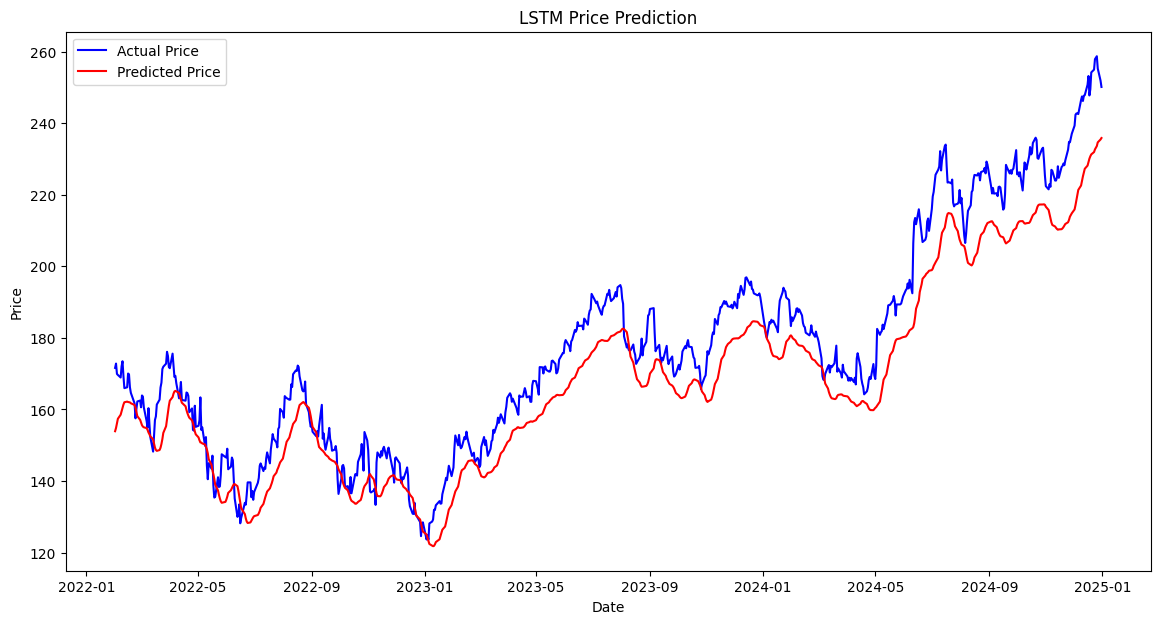

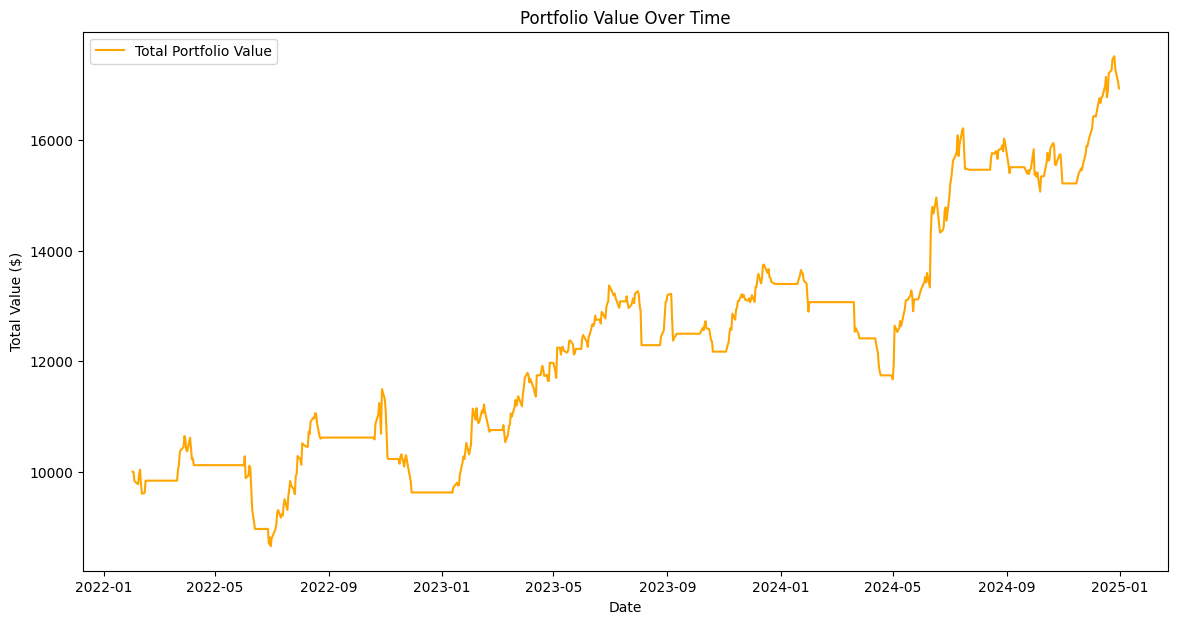

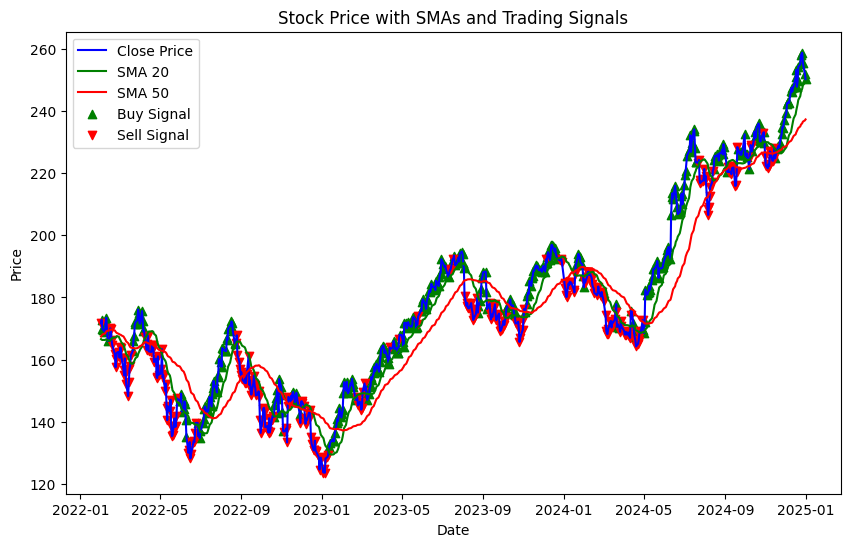

In [13]:
def main():
    ticker = 'AAPL'
    start_date = '2010-01-01'
    end_date = '2025-01-01'
    stock_data = fetch_stock_data(ticker, start_date, end_date)
    stock_data = add_technical_indicators(stock_data)
    sequence_length = 60
    X, y, scaler = prepare_lstm_input(stock_data, sequence_length)
    split = int(0.8 * len(X))
    X_train, y_train = X[:split], y[:split]
    X_test, y_test = X[split:], y[split:]
    model = create_lstm_model((X_train.shape[1], 1))
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    predictions = model.predict(X_test)
    predictions_inv = scaler.inverse_transform(predictions)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
    test_data = stock_data[-len(y_test_inv):]
    trading_signals = generate_trading_signals(predictions_inv)
    trading_signals_series = pd.Series(trading_signals, index=test_data.index)
    portfolio = backtest_trading_strategy(test_data, trading_signals_series)
    total_return, sharpe_ratio, max_drawdown = evaluate_strategy_performance(portfolio)
    print("Total Return:", total_return)
    print("Sharpe Ratio:", sharpe_ratio)
    print("Max Drawdown:", max_drawdown)
    plot_price_predictions(test_data, y_test_inv, predictions_inv)
    plot_portfolio_growth(portfolio)
    plot_trading_signals(test_data, trading_signals_series)

if __name__ == '__main__':
    main()